# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 1B: Basic Concepts III

This notebook begins by revisiting the Lap(Lap()) example from the previous session, this time demonstrating how easily code implemented with GT4Py can be run on an NVIDIA GPU. Note that some parts will not work on Orion, since the Orion system does not have any GPUs.

We first import the necessary packages as before.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gt4py
import gt4py.storage as gt_storage
from gt4py import gtscript
from gt4py.gtscript import Field 

from tools import plot_two_ij_slices

### Define the 2D Laplacian stencil:

In [2]:
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

### Domain Specification

Specify the initial domain sizes: (*n<sub>i</sub>*, *n<sub>j</sub>*, *n<sub>k</sub>*), the number of halo lines in *x* and *y*, *n<sub>halo</sub>*, and the number of times to run each backend, *n<sub>runs</sub>*.

In [3]:
ni, nj, nk = 24, 24, 80
nhalo = 3
nruns = 5

### Generate Scalability Data

Here we define the `origin`, `domain`, data `shape`, and `backends`. The `gtx86` backend is replaced with `gtcuda` to generate CUDA code. The inner loop executes the stencil `nruns` times for each backend, with the horizontal domain size doubled at each iteration to generate scalability timings.

In [4]:
origin = (nhalo, nhalo, 0)
backends = ["numpy", "gtmc", "gtcuda"]

timings = dict()
sizes = dict()

for backend in backends:
    ni = nj = 24
    sizes[backend] = []
    timings[backend] = []    

    for n in range(0, nruns):
        print(f"Running with {backend} backend ({n})...")
        
        domain = (ni, nj, nk)
        shape = (ni + 2 * nhalo, nj + 2 * nhalo, nk)
        
        rand_data = np.random.randn(*shape)        
        in_field = gt_storage.from_array(rand_data, backend, origin, shape, dtype=np.float64)        
        out_field = gt_storage.zeros(backend, origin, shape, np.float64)        
        exec_info = {}

        laplacian = gtscript.stencil(backend, laplacian_def)
        laplacian(in_field, out_field, coeff=0.125, origin=origin, domain=domain, exec_info=exec_info)  # , validate_args=False)
        
        call_time = (exec_info['call_end_time'] - exec_info['call_start_time']) * 1000.
        run_time = (exec_info['run_end_time'] - exec_info['run_start_time']) * 1000.        
        
        timings[backend].append(run_time)
        sizes[backend].append(ni)

        ni *= 2
        nj = ni

Running with numpy backend (0)...
Running with numpy backend (1)...
Running with numpy backend (2)...
Running with numpy backend (3)...
Running with numpy backend (4)...
Running with gtmc backend (0)...
Running with gtmc backend (1)...
Running with gtmc backend (2)...
Running with gtmc backend (3)...
Running with gtmc backend (4)...
Running with gtcuda backend (0)...


NameError: name 'cp' is not defined

### Plot the Performance

The generated timing data can be visualized using `matplotlib`. The *y*-axis is in log scale to highlight the performance improvement from `numpy` to an optimized CPU backend (`gtmc`), and finally to optimized GPU code (`gtcuda`).

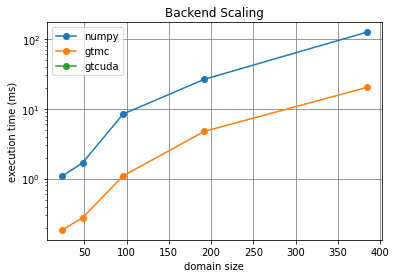

In [5]:
for backend in backends:
    plt.plot(sizes[backend], timings[backend], "-o", label=backend)

plt.title("Backend Scaling")
plt.grid(color="gray", linestyle='-')
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time (ms)")
plt.yscale("log")

plt.show()

### Inspect the Generated Code

Clearly the selected backend can have a significant impact on the performance of the generated code (the target hardware helps too). You may have noticed that stencils run faster the second or third time they are executed. This is because `gt4py` maintains a cache of generated and compiled code in a directory called `.gt_cache`.

We can open a terminal in Jupyter to explore the generated code. The directory format is:<br />
<tt>.gt_cache/py{python_version}/{backend}/{package}/{stencil_name}/m_{stencil_name}_{backend}_{hash}.py</tt>

GT4Py includes a `debug` backend that generates highly readable (if inefficient) Python code from the stencil. We can use the `gtscript.stencil` decorator on the stencil below to quickly generate code for different backends.

For example, the generated code for the `debug` backend would be located here:
<tt>/home/eddied/workshop/notebooks/.gt_cache/py37_1013/debug/__main__/laplacian_def/m_laplacian_def__debug_65d8271266</tt>

<b>Note</b>: The hash is a unique identifier computed from the contents of the stencil. That means if the stencil changes, so will the hash value.

In [6]:
@gtscript.stencil("debug")
def laplacian_def(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

In [7]:
!pygmentize ~/workshop/notebooks/.gt_cache/py37_1013/debug/__main__/laplacian_def/m_laplacian_def__debug_65d8271266.py

import time

import numpy as np
from numpy import dtype

import math


from gt4py.stencil_object import AccessKind, Boundary, DomainInfo, FieldInfo, ParameterInfo, StencilObject


class _Accessor:
    def __init__(self, array, origin):
        self.array = array
        self.origin = origin

    def _shift(self, index):
        return tuple(i + offset for i, offset in zip(index, self.origin))

    def __getitem__(self, index):
        return self.array[self._shift(index)]

    def __setitem__(self, index, value):
        self.array[self._shift(index)] = value


class laplacian_def____debug_65d8271266(StencilObject):
    """


    Default Parameters
    ------------------
    domain : `Sequence` of `int`, optional
        Shape of the computation domain. If `None`, it will be used the
        largest feasible domain according to the provided input fields
        and origin values (`None` by default).

    origin :  `[int * ndims]` or `{'field_name': [int * ndims]}`, optional
        If 

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    (Hint: Make sure that when you modify code you retain the original code by commenting it out so that you undo any of the modifications you do.)
    <ol>
        <li style="margin-bottom: 10px">Extend the <code>laplacian</code> stencil to be a laplacian(laplacian(*)) by introducing a temporary field.</li>
        <li style="margin-bottom: 10px">Replace the redundant code with <code>gtscript.function</code>.</li>
        <li style="margin-bottom: 10px">Open the <code>.gt_cache</code> directory and inspect the generated code.</li>
    </ol>
</div>

In [97]:
# SOLUTION 1:
@gtscript.stencil(backend="numpy")
def diffusion_def1(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        tmp_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])
        out_field = coeff * (-4. * tmp_field +
            tmp_field[1, 0, 0] + tmp_field[-1, 0, 0] + 
            tmp_field[0, 1, 0] + tmp_field[0, -1, 0])

In [98]:
# SOLUTION 2:
@gtscript.function
def laplacian(in_field: Field[np.float], coeff: np.float):
    return coeff * (-4. * in_field +
           in_field[1, 0, 0] + in_field[-1, 0, 0] + 
           in_field[0, 1, 0] + in_field[0, -1, 0])

@gtscript.stencil(backend="numpy")
def diffusion_def2(in_field: Field[np.float], out_field: Field[np.float], *, coeff: np.float):
    with computation(PARALLEL), interval(...):
        tmp_field = laplacian(in_field, coeff)
        out_field = laplacian(tmp_field, coeff)

### Forward and Backward Loops

__TODO__: Add more wording about tridiagonal solvers!

![Tridiagonal Matrix](https://wikimedia.org/api/rest_v1/media/math/render/svg/66abee37b2bc74f82fb79e7e1f0b5475be9f9632)


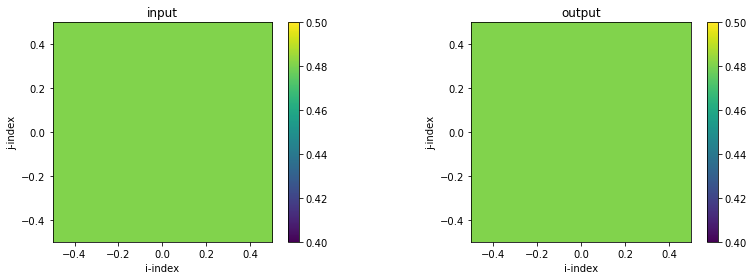

In [99]:
backend = "numpy"
dtype = np.float64
Field3D = Field[dtype]
N = 1024

@gtscript.stencil(backend=backend)
def tridiag_mv_mul(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(PARALLEL):
        with interval(0, 1):
            d = b * x + c * x[0, 0, 1]
        with interval(1, -1):
            d = a * x[0, 0, -1] + b * x + c * x[0, 0, 1]
        with interval(-1, None):
            d = a * x[0, 0, -1] + b * x

@gtscript.stencil(backend=backend)        
def tridiag_solve(a: Field3D, b: Field3D, c: Field3D, d: Field3D, x: Field3D):
    with computation(FORWARD):
        with interval(1, None):
            w = a / b[0, 0, -1]
            b -= w * c[0, 0, -1]
            d -= w * d[0, 0, -1]
    with computation(BACKWARD):
        with interval(-1, None):
            x = d / b
        with interval(0, -1):
            x = (d - c * x[0, 0, 1]) / b


origin = (0, 0, 0)
shape = (1, 1, N)
a = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
b = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
c = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
x0 = gt_storage.from_array(np.random.randn(*shape), backend, origin, dtype=dtype)
d = gt_storage.zeros(backend, origin, shape, dtype=dtype)
x1 = gt_storage.zeros(backend, origin, shape, dtype=dtype)

tridiag_mv_mul(a, b, c, d, x0)
tridiag_solve(a, b, c, d, x1)

plot_two_ij_slices(x0, x1)

<div class="alert alert-block alert-info">
    <b> Now it's your turn: </b><br>
    <ol>
        <li style="margin-bottom: 10px">Implement the Fibonacci sequence in GT4Py using a <tt>FORWARD</tt> loop.</li>
        <li style="margin-bottom: 10px">Change the loop order from <tt>FORWARD</tt> to <tt>BACKWARD</tt> and compare the results.</li>
        <li style="margin-bottom: 10px">Try again with the <tt>PARALLEL</tt> (default) loop order. What has changed? </li>
        <li style="margin-bottom: 10px">Create a parallel sum stencil </li>
    </ol>
</div>

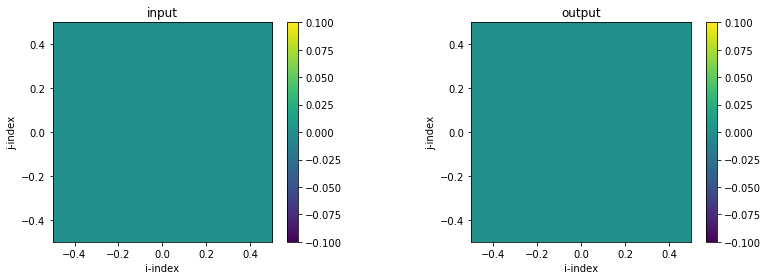

In [100]:
# SOLUTION 1
backend = "numpy"
dtype = np.float
FieldK = Field[dtype, gtscript.K]
N = 64

@gtscript.stencil(backend=backend)
def fibonacci(fib: FieldK):
    with computation(FORWARD):
        with interval(1, 2):
            fib = 1.    # base case...
        with interval(2, None):
            fib = fib[0, 0, -2] + fib[0, 0, -1]
        

fib_gt = gt_storage.zeros(backend, (0, 0, 0), (1, 1, N), dtype)
fibonacci(fib_gt, origin=(0, 0, 0), domain=(1, 1, N))

n = np.arange(0, N)
sqrt5 = np.sqrt(5.)
phi = (1. + sqrt5) / 2.
fib_data = np.rint((phi ** n - (-1. / phi) ** n) / sqrt5)
fib_np = gt_storage.from_array(fib_data, backend, (0, 0, 0), (1, 1, N), dtype=dtype)

plot_two_ij_slices(fib_np, fib_gt)

### Parallel Sum

Implement a parallel sum stencil that sums all of the *k*-values for a 3D field into a single *i*-*j* plane represented by a 2D field.

__Must use a <tt>GridTools</tt> backend!__

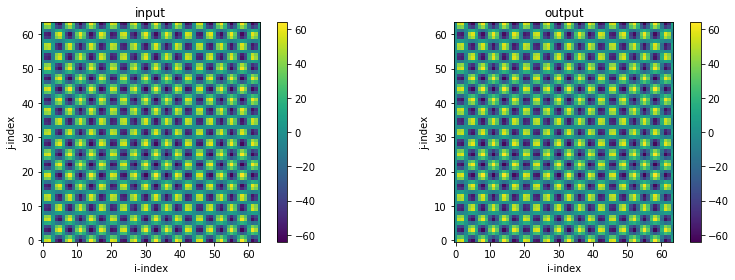

In [101]:
# SOLUTION 2
backend = "gtmc"
dtype = np.float64
Field3D = Field[dtype]
Field2D = Field[dtype, gtscript.IJ]
N = 64

@gtscript.stencil(backend=backend)
def parallel_sum(nums: Field3D, sums: Field2D):
    with computation(PARALLEL), interval(...):
        sums += nums

# GT4Py version...
in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (N, N, N), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (N, N, N), dtype=dtype)  
sums_gt = gt_storage.zeros(backend, (0, 0, 0), (N, N, 1), dtype)

parallel_sum(nums, sums_gt, origin=(0, 0, 0), domain=(N, N, N), validate_args=False)

# NumPy version...
sums_np = gt_storage.zeros(backend, (0, 0, 0), (N, N, 1), dtype=dtype)
sums_np[:, :, 0] = np.sum(nums, 2)

plot_two_ij_slices(sums_np, sums_gt)

### Parallel Count

Probably remove this example is it includes control flow, which will not be covered until Day 2...

In [102]:
backend = "gtmc"
dtype = np.float64
itype = np.int32
Field3D = Field[dtype]
IntField2D = Field[itype, gtscript.IJ]


@gtscript.stencil(backend=backend)
def parallel_count(nums: Field3D, counts: IntField2D):
    with computation(PARALLEL), interval(...):
        if nums > 0.0:
            counts += 1
        

in_data = np.fromfunction(lambda i, j, k: np.sin(i) * np.cos(j), (64, 64, 64), dtype=dtype)
nums = gt_storage.from_array(in_data, backend, (0, 0, 0), (64, 64, 64), dtype=dtype)  
counts = gt_storage.zeros(backend, (0, 0, 0), (64, 64, 1), itype)

parallel_count(nums, counts, origin=(0, 0, 0), domain=(64, 64, 64), validate_args=False)

counts[:, :, 0]

CPUStorage([[ 0,  0,  0, ...,  0,  0,  0],
            [64, 64,  0, ...,  0, 64, 64],
            [64, 64,  0, ...,  0, 64, 64],
            ...,
            [ 0,  0, 64, ..., 64,  0,  0],
            [ 0,  0, 64, ..., 64,  0,  0],
            [64, 64,  0, ...,  0, 64, 64]], dtype=int32)